In [1]:
# https://machinelearningknowledge.ai/image-classification-using-bag-of-visual-words-model/

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

In [3]:
filename = []
label = []
with open('train.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename.append(s[0])
        label.append(int(s[1]))
print(len(label))

63325


In [4]:
filename_test = []
label_test = []
with open('test.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_test.append(s[0])
        label_test.append(int(s[1]))
print(len(label_test))

450


In [5]:
filename_val = []
label_val = []
with open('val.txt', 'r') as f:
    for line in f.readlines():
        s = line.split(' ')
        filename_val.append(s[0])
        label_val.append(int(s[1]))
print(len(label_val))

450


# Shuffle Dataset and split into Training and Testing

In [6]:
dataset_train = []
for i in range(len(filename)):
    dataset_train.append((filename[i],label[i]))
# random.shuffle(dataset_train)

In [7]:
dataset_test = []
for i in range(len(filename_test)):
    dataset_test.append((filename_test[i],label_test[i]))

In [8]:
dataset_val = []
for i in range(len(filename_val)):
    dataset_val.append((filename_val[i],label_val[i]))

In [9]:
image_paths_train, y_train = zip(*dataset_train)
image_paths_test, y_test = zip(*dataset_test)
image_paths_val, y_val = zip(*dataset_val)
print(len(image_paths_train))
print(len(image_paths_test))
print(len(image_paths_val))

63325
450
450


# Feature Extraction using ORB

In [10]:
# 初始化ORB特征检测器对象 (chatgpt)
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8, edgeThreshold=15)

# Function for plotting keypoints

In [11]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

# Plotting the keypoints

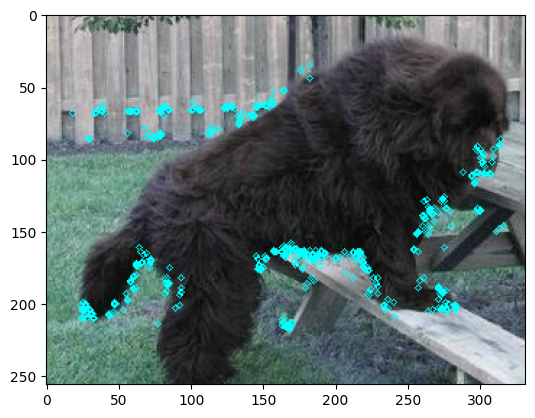

In [12]:
im=cv2.imread(image_paths_train[130])
# 轉為灰度影像
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# 使用直方圖均衡化增加影像對比度
equalized = cv2.equalizeHist(gray)

kp, des = orb.detectAndCompute(equalized, None)
img=draw_keypoints(im,kp)

# Appending descriptors of the training images in list

In [13]:
import cv2
import multiprocessing

def process_image(image_path):
    im=cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(equalized, (5, 5), 0)
    keypoints, descriptor = orb.detectAndCompute(blur, None)
    return (image_path, descriptor)

if __name__ == '__main__':
    des_list = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_train)
    des_list = results


In [14]:
print(len(des_list[0][1]))

500


In [15]:
descriptors=des_list[0][1]
descriptors = np.concatenate([descriptor for _, descriptor in des_list[1:]], axis=0)

In [16]:
descriptors_float=np.array(descriptors).astype(float)

## Performing K Means clustering on Descriptors

In [17]:
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import MiniBatchKMeans

In [18]:
k = 500
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=4096, max_iter=500000).fit(descriptors_float)
voc = kmeans.cluster_centers_
variance = kmeans.inertia_

/home/tailab_paipei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Creating histogram of training image

In [19]:
im_features=np.zeros((len(des_list),k),"float32")
for i in range(len(des_list)):
    words, _ = vq(des_list[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features[i] = np.bincount(words, minlength=k)

## Applying standardisation on training feature

In [20]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

## Create testing image feature 

In [21]:
if __name__ == '__main__':
    des_list_test = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_test)
    des_list_test = results

In [22]:
im_features_test=np.zeros((len(des_list_test),k),"float32")
for i in range(len(des_list_test)):
    words, _ = vq(des_list_test[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_test[i] = np.bincount(words, minlength=k)
im_features_test=stdslr.transform(im_features_test)

## Create validation image feature

In [23]:
if __name__ == '__main__':
    des_list_val = []
    num_processes = 16 # 設定使用的進程數量，可以根據電腦配置調整
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_paths_val)
    des_list_val = results

In [24]:
im_features_val=np.zeros((len(des_list_val),k),"float32")
for i in range(len(des_list_val)):
    words, _ = vq(des_list_val[i][1], voc)

    # 使用bincount函数计算单个图像中每个单词出现的次数，并将结果存储到im_features数组中
    im_features_val[i] = np.bincount(words, minlength=k)
im_features_val=stdslr.transform(im_features_val)

## Creating Classification Model with SVM

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score 

In [29]:
# 定義自定義資料集
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [30]:
# 定義自定義資料集
train_dataset = CustomDataset(im_features, np.array(y_train))
val_dataset = CustomDataset(im_features_val, np.array(y_val))

In [50]:
# 定義DataLoader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# 定義SVM模型
clf = SVC(kernel='linear')
train_accs1=[]
val_accs1=[]
# 訓練模型
for epoch in range(0, 10):
    for X_batch, y_batch in train_loader:
        clf.fit(X_batch, y_batch)
    
    # 計算訓練集和測試集的準確度
    train_preds = clf.predict(im_features)
    train_acc1 = accuracy_score(np.array(y_train), train_preds)
    train_accs1.append(train_acc1)
    
    val_preds = clf.predict(im_features_val)
    val_acc1 = accuracy_score(np.array(y_val), val_preds)
    val_accs1.append(val_acc1)
    
    print(f"Epoch {int(epoch+1):02d}, Train Accuracy: {float(train_acc1):04f}, Validation Accuracy: {float(val_acc1):04f}")

Epoch 01, Train Accuracy: 0.069720, Validation Accuracy: 0.051111
Epoch 02, Train Accuracy: 0.068788, Validation Accuracy: 0.057778
Epoch 03, Train Accuracy: 0.071078, Validation Accuracy: 0.046667
Epoch 04, Train Accuracy: 0.067161, Validation Accuracy: 0.068889
Epoch 05, Train Accuracy: 0.068662, Validation Accuracy: 0.037778
Epoch 06, Train Accuracy: 0.069072, Validation Accuracy: 0.053333
Epoch 07, Train Accuracy: 0.068235, Validation Accuracy: 0.042222
Epoch 08, Train Accuracy: 0.070794, Validation Accuracy: 0.033333
Epoch 09, Train Accuracy: 0.069088, Validation Accuracy: 0.044444
Epoch 10, Train Accuracy: 0.070636, Validation Accuracy: 0.057778


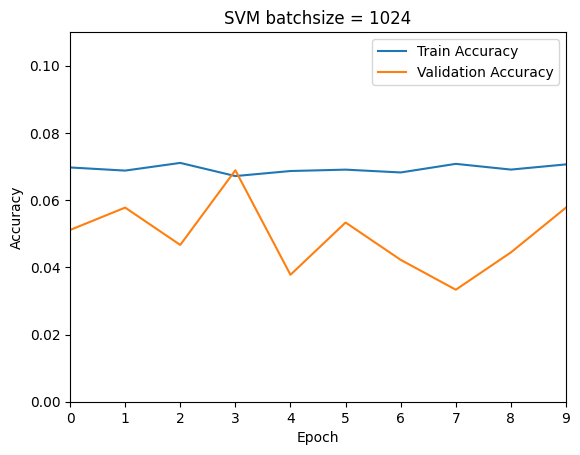

In [52]:
# 繪製準確度曲線
plt.title('SVM batchsize = 1024')
plt.plot(train_accs1, label="Train Accuracy")
plt.plot(val_accs1, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axis([0, 9, 0.0, 0.11])
plt.legend()
plt.show()

In [51]:
# 定義DataLoader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# 定義SVM模型
clf = SVC(kernel='sigmoid')
train_accs2=[]
val_accs2=[]
# 訓練模型
for epoch in range(0, 10):
    for X_batch, y_batch in train_loader:
        clf.fit(X_batch, y_batch)
    
    # 計算訓練集和測試集的準確度
    train_preds = clf.predict(im_features)
    train_acc2 = accuracy_score(np.array(y_train), train_preds)
    train_accs2.append(train_acc2)
    
    val_preds = clf.predict(im_features_val)
    val_acc2 = accuracy_score(np.array(y_val), val_preds)
    val_accs2.append(val_acc2)
    
    print(f"Epoch {int(epoch+1):02d}, Train Accuracy: {float(train_acc2):04f}, Validation Accuracy: {float(val_acc2):04f}")

Epoch 01, Train Accuracy: 0.064351, Validation Accuracy: 0.060000
Epoch 02, Train Accuracy: 0.064114, Validation Accuracy: 0.055556
Epoch 03, Train Accuracy: 0.069214, Validation Accuracy: 0.093333
Epoch 04, Train Accuracy: 0.058887, Validation Accuracy: 0.053333
Epoch 05, Train Accuracy: 0.062661, Validation Accuracy: 0.040000
Epoch 06, Train Accuracy: 0.060340, Validation Accuracy: 0.057778
Epoch 07, Train Accuracy: 0.058381, Validation Accuracy: 0.053333
Epoch 08, Train Accuracy: 0.056818, Validation Accuracy: 0.053333
Epoch 09, Train Accuracy: 0.058697, Validation Accuracy: 0.062222
Epoch 10, Train Accuracy: 0.062819, Validation Accuracy: 0.042222


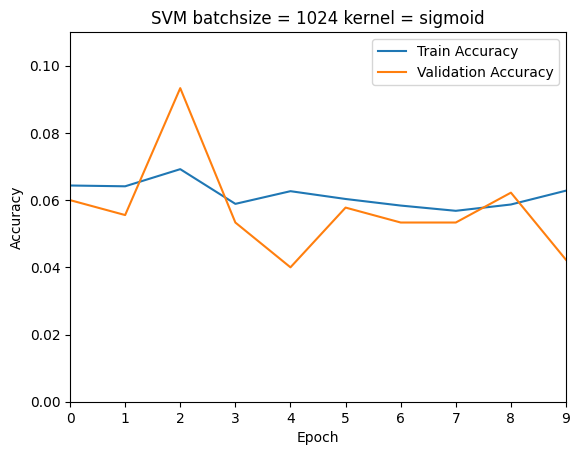

In [54]:
# 繪製準確度曲線
plt.title('SVM batchsize = 1024 kernel = sigmoid')
plt.plot(train_accs2, label="Train Accuracy")
plt.plot(val_accs2, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axis([0, 9, 0.0, 0.11])
plt.legend()
plt.show()

In [31]:
# 定義DataLoader
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)

# 定義SVM模型
clf1 = SVC(kernel='rbf')
train_accs5=[]
val_accs5=[]
test_accs5=[]
# 訓練模型
for epoch in range(0, 10):
    for X_batch, y_batch in train_loader:
        clf1.fit(X_batch, y_batch)
    
    # 計算訓練集和測試集的準確度
    train_preds = clf1.predict(im_features)
    train_acc5 = accuracy_score(np.array(y_train), train_preds)
    train_accs5.append(train_acc5)
    
    val_preds = clf1.predict(im_features_val)
    val_acc5 = accuracy_score(np.array(y_val), val_preds)
    val_accs5.append(val_acc5)

    test_preds = clf1.predict(im_features_test)
    test_acc5 = accuracy_score(np.array(y_test), test_preds)
    test_accs5.append(test_acc5)
    
    print(f"Epoch {int(epoch+1):02d}, Train Accuracy: {float(train_acc5):04f}, Validation Accuracy: {float(val_acc5):04f}\
          ,  Testing Accuracy: {float(test_acc5):04f}")

Epoch 01, Train Accuracy: 0.090754, Validation Accuracy: 0.048889          ,  Testing Accuracy: 0.071111
Epoch 02, Train Accuracy: 0.095918, Validation Accuracy: 0.048889          ,  Testing Accuracy: 0.060000
Epoch 03, Train Accuracy: 0.091717, Validation Accuracy: 0.053333          ,  Testing Accuracy: 0.057778
Epoch 04, Train Accuracy: 0.094544, Validation Accuracy: 0.051111          ,  Testing Accuracy: 0.051111
Epoch 05, Train Accuracy: 0.088338, Validation Accuracy: 0.051111          ,  Testing Accuracy: 0.071111
Epoch 06, Train Accuracy: 0.090596, Validation Accuracy: 0.075556          ,  Testing Accuracy: 0.071111
Epoch 07, Train Accuracy: 0.091749, Validation Accuracy: 0.060000          ,  Testing Accuracy: 0.055556
Epoch 08, Train Accuracy: 0.087248, Validation Accuracy: 0.053333          ,  Testing Accuracy: 0.055556
Epoch 09, Train Accuracy: 0.087311, Validation Accuracy: 0.064444          ,  Testing Accuracy: 0.075556
Epoch 10, Train Accuracy: 0.089049, Validation Accuracy

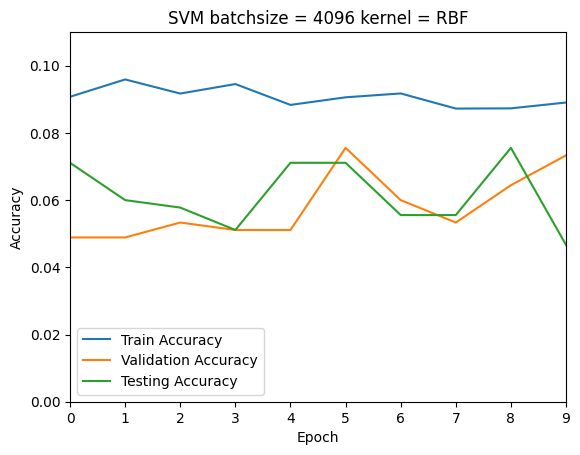

In [33]:
# 繪製準確度曲線
plt.title('SVM batchsize = 2048 kernel = RBF')
plt.plot(train_accs5, label="Train Accuracy")
plt.plot(val_accs5, label="Validation Accuracy")
plt.plot(test_accs5, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axis([0, 9, 0.0, 0.11])
plt.legend()
plt.show()

In [34]:
y_preds_test = clf1.predict(im_features_test)
confusion_mat = confusion_matrix(y_test,y_preds_test)

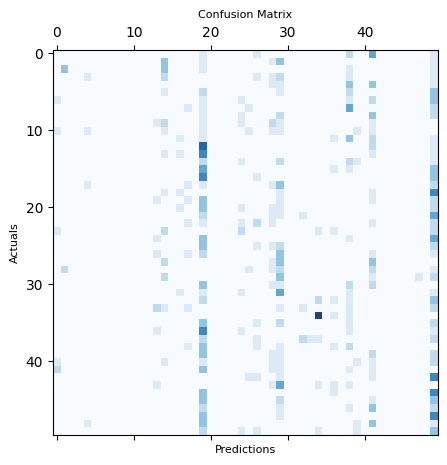

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.9)
# for i in range(confusion_mat.shape[0]):
#     for j in range(confusion_mat.shape[1]):
#         ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()